# Calibration

### Requirements

- Python >= 3.4

- `pip install gsd192_tools numpy pandas lmfit matplotlib scipy dtw-python ipywidgets`

### Import libraries

In [13]:
%matplotlib notebook

# Main calibration library
import gsd192_tools.calibration as calib

# Data processing
import numpy as np
import matplotlib.pyplot as plt
import math

# For multithreading
import multiprocessing

# Interaction / IO
import io
import ipywidgets as widgets
import IPython
import time
from pathlib import Path
import os

### Load file

In [14]:
uploader = widgets.FileUpload(accept='.mca')
display(uploader)

FileUpload(value={}, accept='.mca', description='Upload')

In [15]:
[mca_file] = uploader.data
data = calib.loadMCA(io.BytesIO(mca_file))

### Data before calibration

<IPython.core.display.Javascript object>


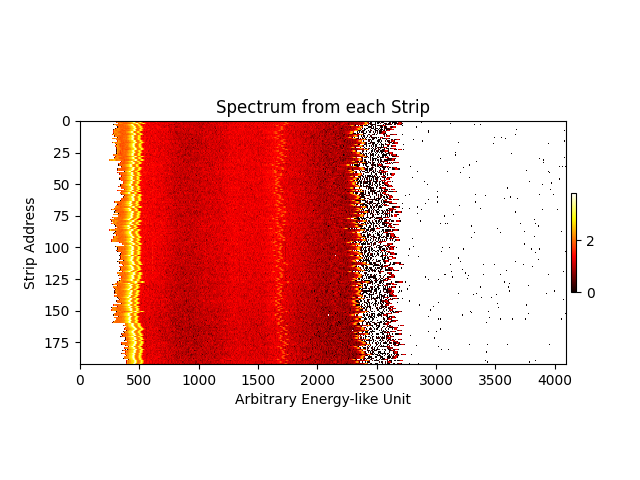

In [16]:
plt.figure(0)
calib.displayPixels(np.log10(data), 0, len(data[0]), "Arbitrary Energy-like Unit")

### Set Known Energies

To be able to calibrate the data, you need to identify some peaks for one pixel. Enter which pixel below

*The vertical position of detected peaks doesn't matter. Only the horizontal location is used*

In [17]:
pixelNumInput = widgets.BoundedIntText(
    value=len(data)/2,
    min=0,
    max=len(data-1),
    step=1,
    description='<b style="color: red;">Pixel #:</b>',
    disabled=False
)

toggleLog = widgets.Checkbox(
    value=True,
    description='Detect peaks on logged data',
    disabled=False,
    indent=True
)

display(pixelNumInput)
display(toggleLog)

BoundedIntText(value=96, description='<b style="color: red;">Pixel #:</b>', max=192)

Checkbox(value=True, description='Detect peaks on logged data')

<IPython.core.display.Javascript object>


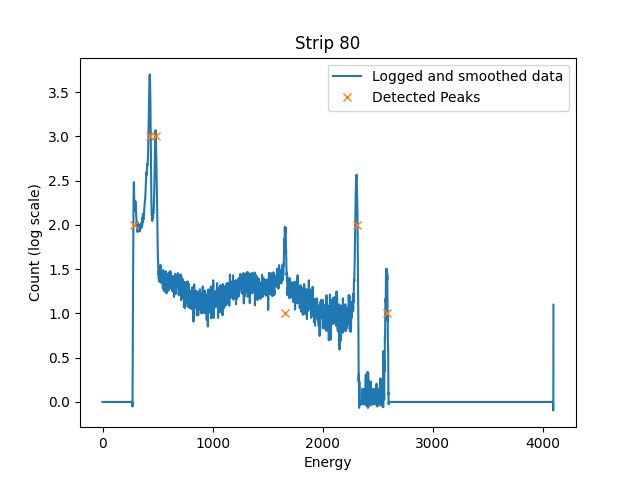

In [18]:
# Adjust this if not enough or too many peaks get detected. Higher -> less peaks (default: 0.09)
#   For non-log peak detect:
prominence = 0.08
#   For log peak detect:
logProminence = 0.5
logMinHeight = 1.5

# If a pixel has very weird data, add it here so it gets ignored
deadPixels = [28]

pixelNum = pixelNumInput.value
useLogPeakDetect = toggleLog.value
plt.figure("Peaks")
plt.ylabel("Count (log scale)")
plt.xlabel("Energy")
plt.title("Strip {}".format(pixelNum))
if useLogPeakDetect:
    d = calib.Pixel(data[pixelNum]).detectPeaksLog(True, prominence=logProminence, minHeight=logMinHeight)
else:
    d = calib.Pixel(data[pixelNum]).detectPeaks(True)

Please use the above plot to find peaks and enter their actual energy values below as `(plot x value, energy)`. Please only inlude peaks that exist in all strips.

In [21]:
energies = [
    #(2560, 136),
    (2290, 122),
    (1646, 88),
    (476, 24.9424),
    (423, 22.16292),
]
#energies = [
#    (1622, 1622/20),
#    (495, 495/20),
#    (441, 441/20)
#]
#energies = [(323, 34), (1948, 200)]
energyUnit = "keV"

### Fast estimate

Now we can start calibrating. First all pixels get aligned with the one chosen pixel using Dynamic Time Warping so (hopefully) all known energy peaks are at the same x-value in each graph. Since dynamic time warping can warp the data significantly, the locations of the energy values are then used to calculate a transformation that mostly doesn't disform the data.

The procedure for this is to first pick one strip and manually define the energies of some peaks in the intensity. Then the following steps are repeated for all strips:

- Detect the peaks in the intensity using `Pixel.detectPeaksLog` or `Pixel.detectPeaks`. Both work, but the log version seems to give slightly better results so far.
- Using `Pixel.usePeakEnergiesFrom`, estimate where the energies defined for the one strip would be on this particular one. This uses `Pixel.transformationTo` internally to get a rough transformation between strips.
- Use `Pixel.getLabeledPeaks` to combine the previous two steps and match the estimated energy locations with the detected peaks to get an exact location for each energy. (This is automatically called by `Pixel.getEnergyXValues`)
- `Pixel.getEnergyXValues` will then output energy values for every point in the original strip data

IntProgress(value=0, description='Pixel 0:', max=192)

Running on 4 cores concurrently


/home/sebastian/miniconda3/lib/python3.7/site-packages/dtw/warp.py:30: RuntimeWarning: invalid value encountered in true_divide
  return numpy.arange(len(n)), s/n
/home/sebastian/miniconda3/lib/python3.7/site-packages/dtw/warp.py:30: RuntimeWarning: invalid value encountered in true_divide
  return numpy.arange(len(n)), s/n
/home/sebastian/miniconda3/lib/python3.7/site-packages/dtw/warp.py:30: RuntimeWarning: invalid value encountered in true_divide
  return numpy.arange(len(n)), s/n
/home/sebastian/miniconda3/lib/python3.7/site-packages/dtw/warp.py:30: RuntimeWarning: invalid value encountered in true_divide
  return numpy.arange(len(n)), s/n


Warping 192 strips took a total of 95.00349164009094 seconds (0.4948098572591941 sec/strip)


<IPython.core.display.Javascript object>


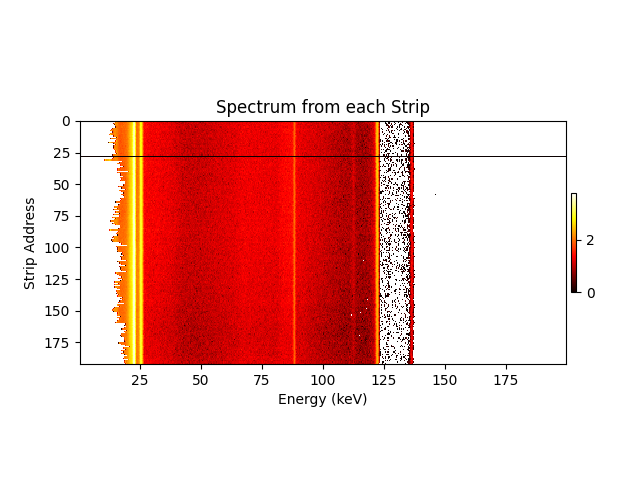

In [22]:
progress = widgets.IntProgress(
    value=0,
    min=0,
    max=len(data),
    step=1,
    description='Pixel 0:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)
display(progress)

energies = sorted(energies, key=lambda energy : energy[0])

startTime = time.time()

pixelWithDefinedEnergies = calib.Pixel(data[pixelNum], peakEnergies=energies, pixelNumber=pixelNum, prominenceScaleFactor=prominence)
    
def doPixel(n):    
    if n in deadPixels:
        # Add zero data for dead pixel
        progress.value=n
        return ([0], [0]), None
    
    # Create a new pixel instance for each strip
    px = calib.Pixel(data[n], pixelNumber=n, prominenceScaleFactor=prominence)
    px.detectPeaksLog(prominence=logProminence, minHeight=logMinHeight)
    # Analyze the transformation between pixels using DTW and apply the transformation to the energies defined for the other pixel
    px.usePeakEnergiesFrom(pixelWithDefinedEnergies, showPlot=False)
    # Calculate the x values for each point in the original dataset that would put it at the correct energy
    #plt.figure("p"+str(n))
    xdata = px.getEnergyXValues(showPlot=False)
    
    pixelMin = min(xdata)
    pixelMax = max(xdata)
    
    progress.value=n
    progress.description="Pixel "+str(n)+":"
    
    # Check if calculated energies are realistic
    if pixelMin < -energies[-1][1]*len(data[n])/energies[-1][0]*.5 or pixelMax > energies[-1][1]*len(data[n])/energies[-1][0]*2:
        # It can happen that some peaks don't get detected correctly and the resulting calculated energy values will be all over the place
        print("Strip number {} couldn't be peak detected and adjusted correctly. This could be caused by bad data (which should be just excluded) or poor choice of peak prominence threshold".format(n))
        plt.figure("Strip {} data and peaks".format(n))
        plt.plot(px.data, label="Data")
        plt.plot(*zip(*px.peaks), marker="x", linestyle='None', label="Detected peaks")
        plt.legend()
        return ([0], [0]), px
    else:
        return (np.log10(px.data), xdata), px
       
# Check if the server is running on Windows
if os.name == 'nt':
    # Multiprocessing seems to have issues with IPython on Windows. It just runs forever without doing anything
    print("Detected a windows environment on the server. Defaulting to a single thread ...")
    adjustedPixels = []
    pixels = []
    for n in range(len(data)):
        res = doPixel(n)
        adjustedPixels.append(res[0])
        pixels.append(res[1])
else:
    print("Running on {} cores concurrently".format(multiprocessing.cpu_count()))
    # Multiprocessing can vastly improve the calculation time since python runs in a single thread and only uses one CPU core
    p = multiprocessing.Pool(multiprocessing.cpu_count())
    # Let the multiprocessing pool call the doPixel function for every strip
    res = [*zip(*p.map(doPixel, list(range(len(data)))))]

    adjustedPixels = res[0]
    pixels = res[1]
       
# Calculate a window for which data exists in all strips
xmax = min([max(p[1]) if p is not None and len(p[1])>1 else math.inf for p in adjustedPixels])
xmin = max([min(p[1]) if p is not None and len(p[1])>1 else -math.inf for p in adjustedPixels])
    
print("Warping {} strips took a total of {} seconds ({} sec/strip)".format(len(data), time.time()-startTime, (time.time()-startTime)/len(data)))
    
plt.figure("Adjusted Strips")
dataRange = np.asarray(range(math.floor(xmin)*10, math.ceil(xmax)*10, max(1, int((xmin-xmax)/1000))))/10
imData = np.asarray([(np.interp(dataRange, strip[1], strip[0]) if strip else np.asarray([0]*len(dataRange))) for strip in adjustedPixels])
calib.displayPixels(imData, xmin, xmax, xlabel="Energy ({})".format(energyUnit))

### Curve Fitting

To sqeeze out the last bit of accuracy, we can then curve fit the data to get a more exact location for the peaks used to align the strips. The curve fit model and initial parameters are largely based on the peaks detected in the graph with the peaks. If there are any peaks that you are unsure if they will get detected, add them here as `(x, y)` tuples.

This will be quickest if only peaks with known energy values get detected.

In [9]:
additionalPeaks = [
    (406, 4500)
]
energies.append((406, 21.9903))

IntProgress(value=0, description='Pixel 0:', max=191)

/home/sebastian/miniconda3/lib/python3.7/site-packages/dtw/warp.py:30: RuntimeWarning: invalid value encountered in true_divide
  return numpy.arange(len(n)), s/n
/home/sebastian/miniconda3/lib/python3.7/site-packages/dtw/warp.py:30: RuntimeWarning: invalid value encountered in true_divide
  return numpy.arange(len(n)), s/n
/home/sebastian/miniconda3/lib/python3.7/site-packages/dtw/warp.py:30: RuntimeWarning: invalid value encountered in true_divide
  return numpy.arange(len(n)), s/n
/home/sebastian/miniconda3/lib/python3.7/site-packages/dtw/warp.py:30: RuntimeWarning: invalid value encountered in true_divide
  return numpy.arange(len(n)), s/n


Curve Fitting 192 strips took a total of 299.63649249076843 seconds (1.560606736689806 sec/strip)


<IPython.core.display.Javascript object>


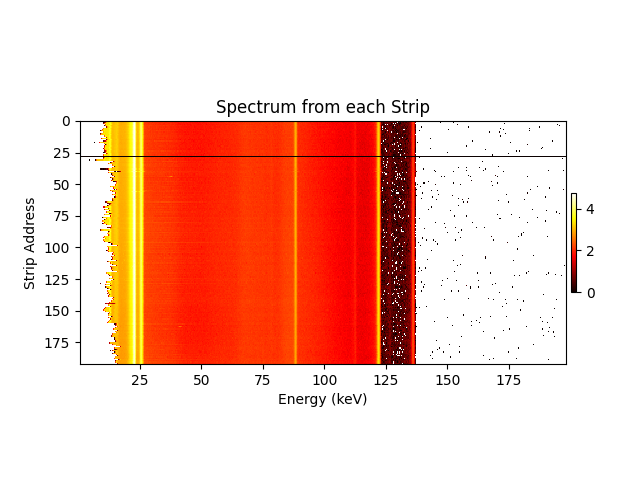

In [11]:
progress = widgets.IntProgress(
    value=0,
    min=0,
    max=len(data)-1,
    step=1,
    description='Pixel 0:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)
display(progress)

startTime = time.time()

pixelWithDefinedEnergies.curveFit(additionalPeaks=additionalPeaks)

def fitPixel(px):
    if px is None:
        return ([0], [0])
    progress.value=px.number
    progress.description="Pixel "+str(px.number)+":"
    
    px.curveFit(reuseAdditionalPeaksFrom=pixelWithDefinedEnergies)
    xdata = px.getEnergyXValues()
    return (np.log10(px.data), xdata), px
    
if os.name == 'nt':
    adjustedPixels = []
    for px in pixels:
        adjustedPixels.append(fitPixel(px)[0])
else:
    print("Running curve fit on {} cores concurrently".format(multiprocessing.cpu_count()))
    p = multiprocessing.Pool(multiprocessing.cpu_count())
    res = [*zip(*p.map(fitPixel, pixels))]
    adjustedPixels = res[0]
    pixels = res[1]
    
print("Curve Fitting {} strips took a total of {} seconds ({} sec/strip)".format(len(data), time.time()-startTime, (time.time()-startTime)/len(data)))
    
plt.figure(4)
imData = np.asarray([(np.interp(np.asarray(range(math.floor(xmin)*10, math.ceil(xmax)*10))/10, strip[1], strip[0]) if strip else np.asarray([0]*10*(math.ceil(xmax) - math.floor(xmin)))) for strip in adjustedPixels])
calib.displayPixels(imData, xmin, xmax, xlabel="Energy ({})".format(energyUnit))

### Download calibration files

*This cell can be executed as soon as there is calibrated data. It doesn't have to be after the curve fit.*

The first file is formatted very similarly to the input mca file and contains energy values for every point in the original mca file. The second one just contains the input energy values and their location in each strip.

In [17]:
name = ".".join(uploader.metadata[0]['name'].split(".")[:-1])

calibrationFileText = calib.toCalibrationFile([px for px in pixels if px], name, energyUnit)
peakFileText = calib.toPeakFile([px for px in pixels if px], name, energyUnit)

Path("calibration_download_tmp_deleteme").mkdir(parents=True, exist_ok=True)

calibrationFile = open("calibration_download_tmp_deleteme/{}.cal".format(name), 'w')
peakFile = open("calibration_download_tmp_deleteme/{}.calp".format(name), 'w')

calibrationFile.write(calibrationFileText)
peakFile.write(peakFileText)

display(IPython.core.display.HTML('<a href="calibration_download_tmp_deleteme/{}" target="_blank" download="calibration_file.cal">Calibration File</a>'.format(calibrationFile.name.split("/")[-1])))
display(IPython.core.display.HTML('<a href="calibration_download_tmp_deleteme/{}" target="_blank" download="calibration_peak_file.calp">Calibration Peak File</a>'.format(peakFile.name.split("/")[-1])))

calibrationFile.close()
peakFile.close()

### Cleanup

Optionally delete tmp folder used to store files available for download (about 7 MB per calibration). **This should only be done *after* downloading the files from the cell above**

In [16]:
import shutil

shutil.rmtree("calibration_download_tmp_deleteme", ignore_errors=True)